# Training Script 
This notebook uses the different algorithms for training

In [1]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()

In [9]:
import tensorflow as tf
import matplotlib.pyplot as plt

def plot_images(images, masks, num_images=8):
    fig, ax = plt.subplots(2, num_images, figsize=(20, 5))
    for i in range(num_images):
        ax[0, i].imshow(images[i])
        ax[0, i].axis('off')
        ax[1, i].imshow(masks[i].squeeze(), cmap='gray')
        ax[1, i].axis('off')
    plt.show()
    
path = "/workspaces/Satelite/data/dataset_upscaled_False/train"
train_data = tf.data.Dataset.load(path)

# Load the images and masks
images = []
masks = []

for image, mask in train_data.take(100):
    print(image.shape, mask.shape)
    images.append(image.numpy())
    masks.append(mask.numpy())

# Plot the images and masks
#plot_images(images, masks, num_images=8)

(256, 256, 4) (512, 512, 106)
(256, 256, 4) (512, 512, 106)
(256, 256, 4) (512, 512, 106)
(256, 256, 4) (512, 512, 106)
(256, 256, 4) (512, 512, 106)
(256, 256, 4) (512, 512, 106)
(256, 256, 4) (512, 512, 106)
(256, 256, 4) (512, 512, 106)
(256, 256, 4) (512, 512, 106)
(256, 256, 4) (512, 512, 106)
(256, 256, 4) (512, 512, 106)
(256, 256, 4) (512, 512, 106)
(256, 256, 4) (512, 512, 106)
(256, 256, 4) (512, 512, 106)
(256, 256, 4) (512, 512, 106)
(256, 256, 4) (512, 512, 106)
(256, 256, 4) (512, 512, 106)
(256, 256, 4) (512, 512, 106)
(256, 256, 4) (512, 512, 106)
(256, 256, 4) (512, 512, 106)
(256, 256, 4) (512, 512, 106)
(256, 256, 4) (512, 512, 106)
(256, 256, 4) (512, 512, 106)
(256, 256, 4) (512, 512, 106)
(256, 256, 4) (512, 512, 106)
(256, 256, 4) (512, 512, 106)
(256, 256, 4) (512, 512, 106)
(256, 256, 4) (512, 512, 106)
(256, 256, 4) (512, 512, 106)
(256, 256, 4) (512, 512, 106)
(256, 256, 4) (512, 512, 106)
(256, 256, 4) (512, 512, 106)
(256, 256, 4) (512, 512, 106)
(256, 256,

In [8]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy
from helpers.load import LoadandAugment
from helpers import model

# Define the input shape and number of classes
input_shape = (256, 256, 4)
NUM_CLASSES = 106

# Define the conv_block function
def conv_block(inputs, filter_size, num_filters, dropout_rate, batch_norm):
    conv = layers.Conv2D(num_filters, filter_size, padding='same')(inputs)
    if batch_norm:
        conv = layers.BatchNormalization()(conv)
    conv = layers.Activation('relu')(conv)
    if dropout_rate > 0:
        conv = layers.Dropout(dropout_rate)(conv)
    conv = layers.Conv2D(num_filters, filter_size, padding='same')(conv)
    if batch_norm:
        conv = layers.BatchNormalization()(conv)
    conv = layers.Activation('relu')(conv)
    return conv

def DeepUnet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):
    '''
    UNet, 
    
    '''
    # network structure
    FILTER_NUM = 32 # number of filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters

    inputs = layers.Input(input_shape, dtype=tf.float32)

    # Downsampling layers
    # DownRes 1, convolution + pooling
    conv_256 = conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_128 = layers.MaxPooling2D(pool_size=(2,2))(conv_256)
    # DownRes 2
    conv_128 = conv_block(pool_128, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 3
    conv_64 = conv_block(pool_64, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 4
    conv_32 = conv_block(pool_32, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 5, convolution only
    conv_16 = conv_block(pool_16, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_16)
    up_32 = layers.concatenate([up_32, conv_32], axis=3)
    up_conv_32 = conv_block(up_32, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, conv_64], axis=3)
    up_conv_64 = conv_block(up_64, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, conv_128], axis=3)
    up_conv_128 = conv_block(up_128, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    up_256 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_128)
    up_256 = layers.concatenate([up_256, conv_256], axis=3)
    up_conv_256 = conv_block(up_256, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    
    # Final upsampling to reach (512, 512)
    up_512 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_256)
    up_conv_512 = conv_block(up_512, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layer
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_512)
    
    # Model 
    model = models.Model(inputs, conv_final, name="UNet")
    print(model.summary())
    return model

# Initialize the UNET model with the correct input shape and number of classes
UNET = DeepUnet(input_shape, NUM_CLASSES=NUM_CLASSES, dropout_rate=0, batch_norm=True)

# Base path for the dataset
path = "/workspaces/Satelite/data/dataset_upscaled_False"
train_path = os.path.join(path, "train")
val_path = os.path.join(path, "val")
test_path = os.path.join(path, "test")

# Initialize data loaders with the correct target shape
train_data = LoadandAugment(train_path, "train", 8, False)
val_data = LoadandAugment(val_path, "val", 8, False)

# See shape of the data
print(train_data.dataset.element_spec)
print(val_data.dataset.element_spec)


# Compile the UNET model for multi-class classification
UNET.compile(optimizer='adam', loss=CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# Setup the model checkpoint callback to save the best model
checkpoint_callback = ModelCheckpoint(
    'best_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min'
)

# Train the model
UNET.fit(
    train_data.dataset, 
    validation_data=val_data.dataset, 
    epochs=100, 
    callbacks=[checkpoint_callback]
)


Model: "UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 256, 256, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_199 (Conv2D)            (None, 256, 256, 32  1184        ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_175 (Batch  (None, 256, 256, 32  128        ['conv2d_199[0][0]']             
 Normalization)                 )                                                              

In [9]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from helpers.load import LoadandAugment
from helpers import model

# Define the input shape and number of classes
input_shape = (256, 256, 4)
NUM_CLASSES = 106

# Initialize the UNET model with the correct input shape and number of classes
UNET = model.DeepUnet(input_shape, NUM_CLASSES=NUM_CLASSES, dropout_rate=0, batch_norm=True)

# Base path for the dataset
path = "/workspaces/Satelite/data/dataset_upscaled_False"
train_path = os.path.join(path, "train")
val_path = os.path.join(path, "val")
test_path = os.path.join(path, "test")

# Initialize data loaders with the correct target shape
train_data = LoadandAugment(train_path, "train", 8, False)
val_data = LoadandAugment(val_path, "val", 8, False)

# Compile the UNET model for multi-class classification
UNET.compile(optimizer='adam', loss=SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# Setup the model checkpoint callback to save the best model
checkpoint_callback = ModelCheckpoint(
    'best_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min'
)

# Train the model
UNET.fit(
    train_data.dataset, 
    validation_data=val_data.dataset, 
    epochs=100, 
    callbacks=[checkpoint_callback]
)


Model: "UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 256, 256, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_220 (Conv2D)            (None, 256, 256, 32  1184        ['input_9[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_195 (Batch  (None, 256, 256, 32  128        ['conv2d_220[0][0]']             
 Normalization)                 )                                                              

InvalidArgumentError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/tfuser/.local/lib/python3.8/site-packages/ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "/home/tfuser/.local/lib/python3.8/site-packages/traitlets/config/application.py", line 1075, in launch_instance
      app.start()
    File "/home/tfuser/.local/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 739, in start
      self.io_loop.start()
    File "/home/tfuser/.local/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/home/tfuser/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "/home/tfuser/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "/home/tfuser/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
      await result
    File "/home/tfuser/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "/home/tfuser/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "/home/tfuser/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "/home/tfuser/.local/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/tfuser/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/home/tfuser/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/home/tfuser/.local/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/tfuser/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/tfuser/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/tfuser/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_61003/1718633447.py", line 36, in <module>
      UNET.fit(
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1051, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1109, in compute_loss
      return self.compiled_loss(
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/usr/local/lib/python3.8/dist-packages/keras/losses.py", line 142, in __call__
      losses = call_fn(y_true, y_pred)
    File "/usr/local/lib/python3.8/dist-packages/keras/losses.py", line 268, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/losses.py", line 2078, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "/usr/local/lib/python3.8/dist-packages/keras/backend.py", line 5660, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
logits and labels must have the same first dimension, got logits shape [2097152,106] and labels shape [222298112]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_82542]

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import tensorflow as tf
import rasterio
from numba import cuda
from pathlib import Path
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import BinaryCrossentropy
from load import LoadandAugment
import model

# Reset the GPU memory:
device = cuda.get_current_device()
device.reset()


class Predict:
    """ 
    This class predicts on the data and transforms the predicted values to 
    .tif files. 
    """
    def __init__(self, dataset_path, augmentation, modelname, experiment_name, upscale=False):
        self.experiment_name = experiment_name
        self.dataset_path = dataset_path
        self.train_path = os.path.join(self.dataset_path, "train")
        self.test_path = os.path.join(self.dataset_path, "test")
        self.val_path = os.path.join(self.dataset_path, "val")
        self.train_data = None
        self.val_data = None
        self.test_data = None
        
        if modelname == 'unet':
            self.model = model.unet(self.input_shape, self.num_classes, self.dropout_rate, self.batch_norm)
            self.model.load_weights(f"experiments/{self.experiment_name}/best_model.h5")
        elif modelname == 'attunet':
            self.model = model.attunet(self.input_shape, self.num_classes, self.dropout_rate, self.batch_norm)
        elif modelname == 'resunet':
            self.model = model.resunet(self.input_shape, self.num_classes, self.dropout_rate, self.batch_norm)
        else:
            raise ValueError(f"Model {modelname} not implemented")
        
        
        
    def predict_on_test_data(self):
        """
        This method predicts on the test data and saves the predictions as .tif files.
        """
        # Load the test data
        test_data = LoadandAugment(self.test_path, "test", 8, False)
        
        # Load the model
        model = tf.keras.models.load_model("best_model.h5")
        
        # Predict on the test data
        predictions = model.predict(test_data.dataset)
        
        # Save the predictions as .tif files
        for i, prediction in enumerate(predictions):
            # Get the image path
            image_path = os.path.join(self.test_path, f"image_{i}.tif")
            with rasterio.open(image_path) as src:
                profile = src.profile
                profile.update(dtype=rasterio.uint8, count=1)
                with rasterio.open(f"prediction_{i}.tif", 'w', **profile) as dst:
                    dst.write(prediction, 1)
        


1/1 [==============================] - 1s 929ms/step
Min prediction value: 0.0
Max prediction value: 1.0


IndexError: index 5 is out of bounds for axis 0 with size 5

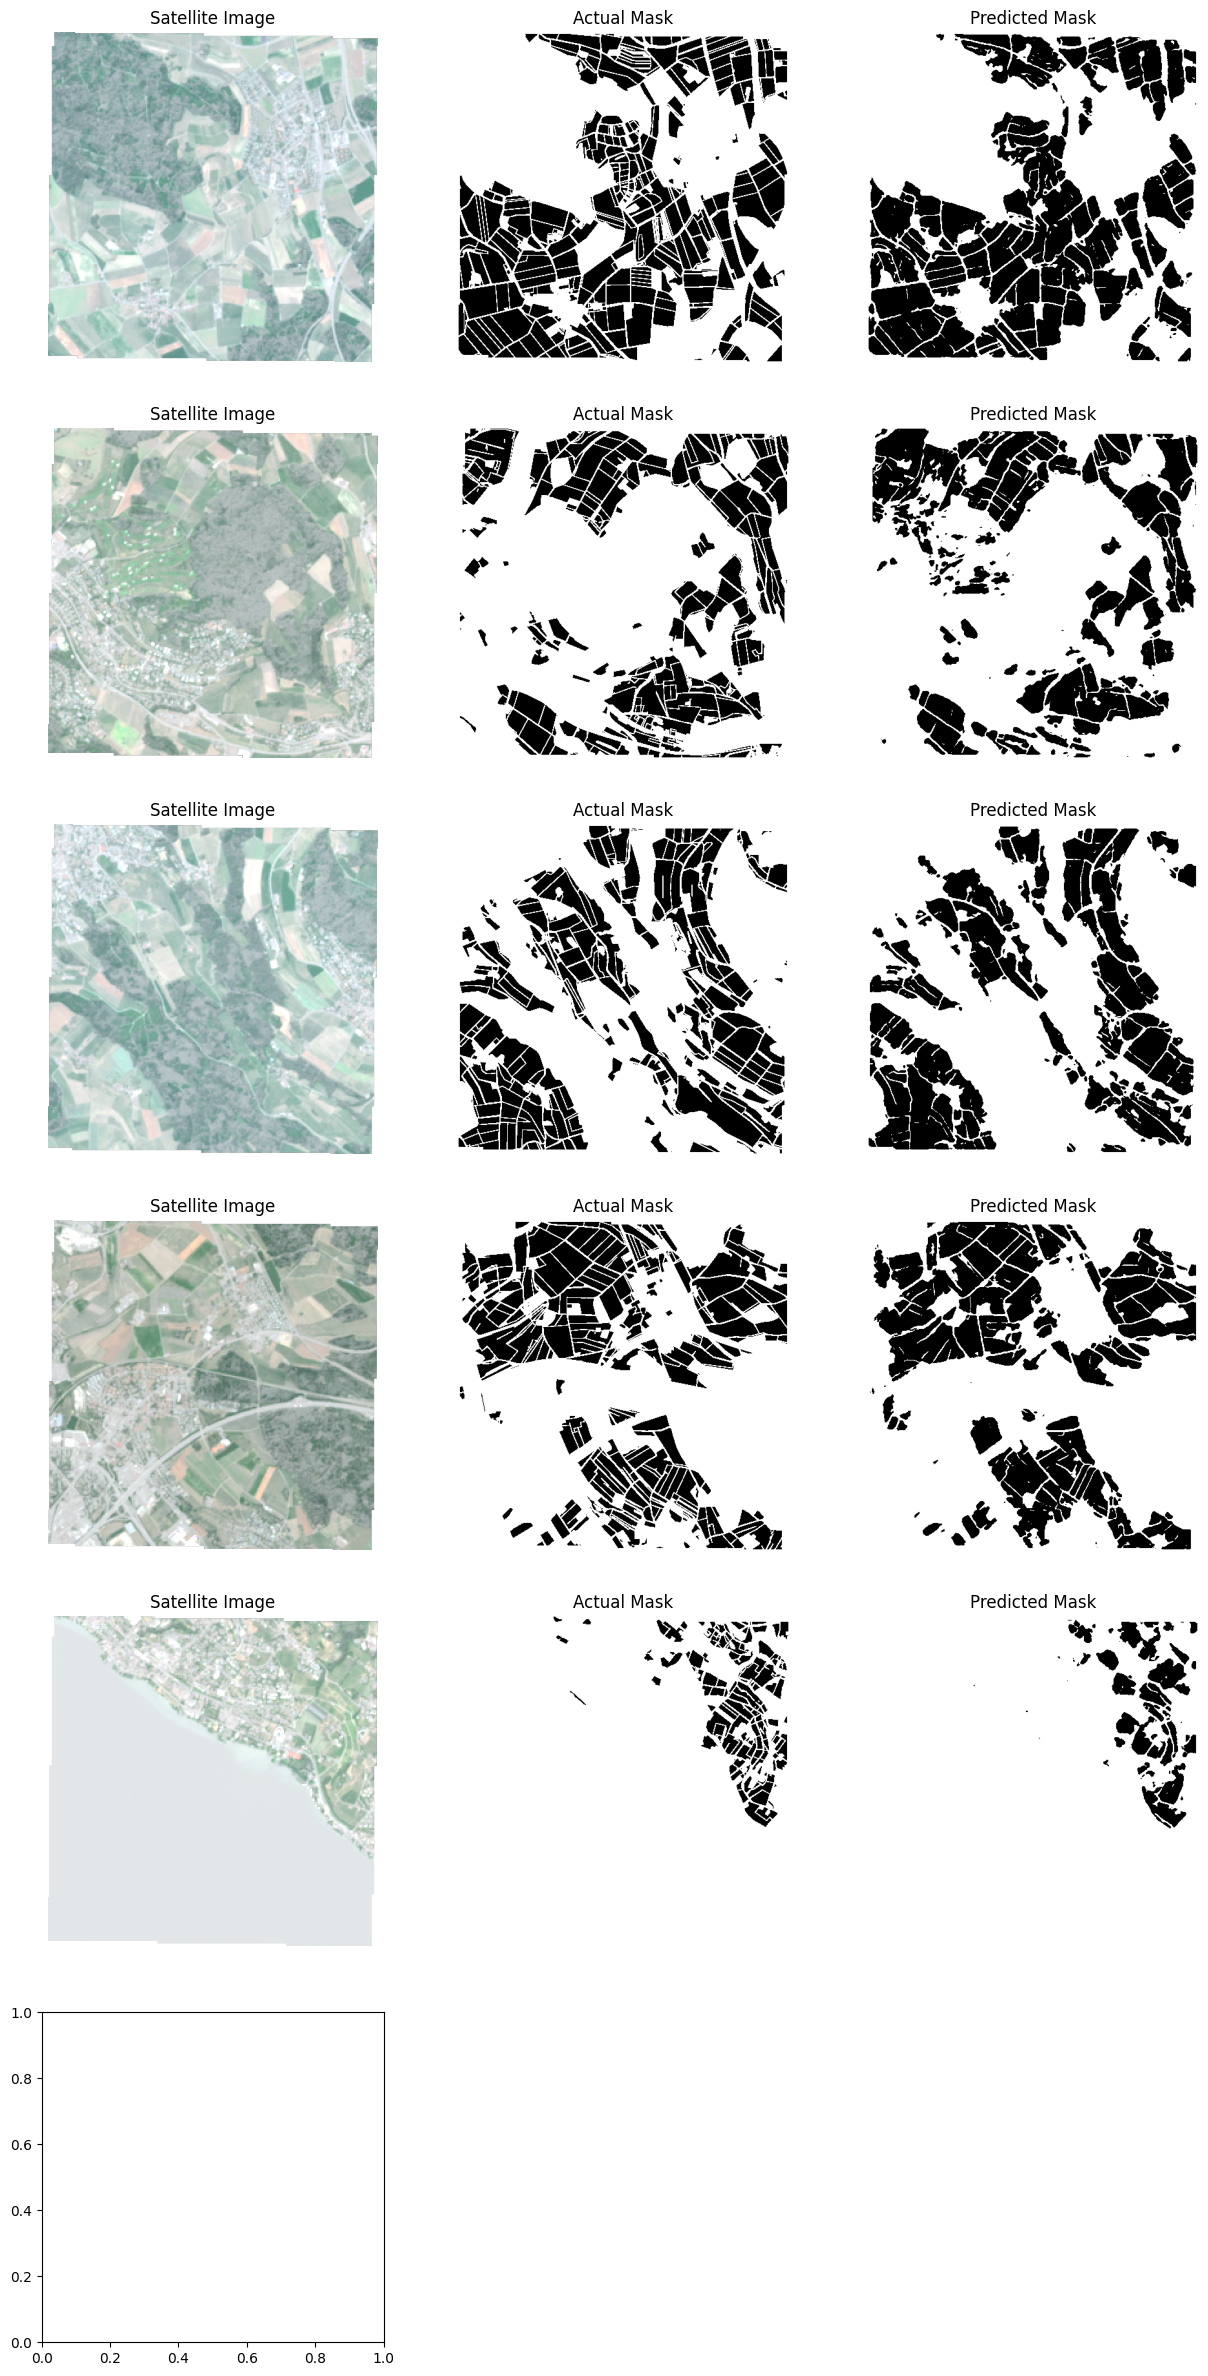

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import tensorflow as tf
import rasterio
from rasterio.transform import from_origin
from helpers.load import LoadandAugment

# Base path for the dataset
path = "/workspaces/Satelite/data/dataset_upscaled_False"
test_path = os.path.join(path, "test")

#  Load the test file mapping
with open('/workspaces/Satelite/data/dataset_upscaled_False/test_file_mapping.json', 'r') as f:
    test_file_mapping = json.load(f)

def plot_predictions(images, masks, predictions, num=6):
    plt.figure(figsize=(15, 5*num))
    
    for i in range(num):
        plt.subplot(num, 3, i*3+1)
        plt.imshow(images[i])
        plt.title("Satellite Image")
        plt.axis('off')
        
        plt.subplot(num, 3, i*3+2)
        plt.imshow(masks[i], cmap='gray')
        plt.title("Actual Mask")
        plt.axis('off')

        plt.subplot(num, 3, i*3+3)
        plt.imshow(predictions[i].squeeze(), cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Load model and weights
UNET.load_weights('best_model.h5')
test_data_loader = LoadandAugment(test_path, "test", 5, True)

# Get the test dataset
test_dataset = test_data_loader.dataset

# Predict on the test data
for images, masks in test_dataset.take(1):
    predictions = UNET.predict(images)
    predictions = (predictions > 0.5).astype(np.float32) 

# Check predictions
print("Min prediction value:", predictions.min())
print("Max prediction value:", predictions.max())

# Save predictions as .tif files
for idx, prediction in enumerate(predictions):
    # Get the original mask path
    original_mask_path = test_file_mapping[idx]["mask"]
    
    # Read the original mask to get the metadata
    with rasterio.open(original_mask_path) as src:
        metadata = src.meta.copy()
        metadata.update({
            "count": 1,
            "dtype": 'float32'
        })
        
        # Save the predicted mask with the same metadata
        predicted_mask_path = original_mask_path.replace('mask', 'predicted_mask')
        with rasterio.open(predicted_mask_path, 'w', **metadata) as dst:
            dst.write(prediction.squeeze(), 1)

# Plot the predictions
plot_predictions(images.numpy(), masks.numpy(), predictions)


In [4]:
import os
import numpy as np
import geopandas as gpd
from skimage import io
from skimage.measure import find_contours
from shapely.geometry import Polygon
from rdp import rdp
import matplotlib.pyplot as plt

# Define the paths
predicted_mask_folder = '/workspaces/Satelite/data/predicted_mask'
original_mask_path = "/workspaces/Satelite/data/mask"

# Get the list of predicted and original mask filenames
predicted_mask_files = [file for file in os.listdir(predicted_mask_folder) if file.endswith('.tif')]
original_mask_files = [file for file in os.listdir(original_mask_path) if file.endswith('.tif')]

# Find the common filenames
common_files = set(predicted_mask_files).intersection(set(original_mask_files))

# Sort the common filenames
common_files = sorted(common_files)

# Read the masks in sorted order
predicted_masks = [io.imread(os.path.join(predicted_mask_folder, file)) for file in common_files]
original_masks = [io.imread(os.path.join(original_mask_path, file)) for file in common_files]

def extract_polygons(mask):
    # Rotate the mask if needed (assuming 90 degrees clockwise rotation)
    mask = np.rot90(mask, k=-1)
    
    # Find contours in the mask
    contours = find_contours(mask, level=0.5)
    
    # Create an empty list to store the polygons
    polygons = []
    
    # Iterate over each contour
    for contour in contours:
        # Simplify the contour using Ramer-Douglas-Peucker algorithm
        simplified_contour = rdp(contour, epsilon=1.0)
        
        # Check if the simplified contour has at least 4 coordinates
        if len(simplified_contour) >= 4:
            # Create a Polygon object from the simplified contour
            polygon = Polygon(simplified_contour)
            
            # Append the polygon to the list
            polygons.append(polygon)
    
    return polygons

def create_geodataframe(polygons, crs='EPSG:32632'):
    # Create a GeoDataFrame from the list of polygons
    gdf = gpd.GeoDataFrame(geometry=polygons)
    
    # Set the CRS of the GeoDataFrame
    gdf.set_crs(crs, inplace=True)
    
    return gdf

def save_geodataframe(gdf, filename):
    # Save the GeoDataFrame to a file (e.g., GeoPackage)
    gdf.to_file(filename, driver="GPKG")

# Extract polygons for original and predicted masks
original_polygons = [extract_polygons(mask) for mask in original_masks]
predicted_polygons = [extract_polygons(mask) for mask in predicted_masks]

# Create GeoDataFrames for original and predicted masks
original_gdfs = [create_geodataframe(polygons) for polygons in original_polygons]
predicted_gdfs = [create_geodataframe(polygons) for polygons in predicted_polygons]

# Save the GeoDataFrames to files
for i, filename in enumerate(common_files):
    original_filename = f"original_{filename.split('.')[0]}.gpkg"
    predicted_filename = f"predicted_{filename.split('.')[0]}.gpkg"
    
    save_geodataframe(original_gdfs[i], original_filename)
    save_geodataframe(predicted_gdfs[i], predicted_filename)

print("GeoDataFrames saved successfully.")


GeoDataFrames saved successfully.


In [ ]:

# Rotate the mask if needed (assuming 90 degrees clockwise rotation)
mask = np.rot90(mask, k=-1)

# Find contours in the mask
contours = find_contours(mask, level=0.5)

# Create an empty list to store the polygons
polygons = []

# Iterate over each contour
for contour in contours:
    # Simplify the contour using Ramer-Douglas-Peucker algorithm
    simplified_contour = rdp(contour, epsilon=1.0)
    
    # Check if the simplified contour has at least 4 coordinates
    if len(simplified_contour) >= 4:
        # Create a Polygon object from the simplified contour
        polygon = Polygon(simplified_contour)
        
        # Append the polygon to the list
        polygons.append(polygon)

# Create a GeoDataFrame from the list of polygons
gdf = gpd.GeoDataFrame(geometry=polygons)

# Set the CRS of the GeoDataFrame (replace 'EPSG:4326' with the appropriate CRS)
# EPSG:32632 - WGS 84 / UTM zone 32N

# Save the GeoDataFrame to a file (e.g., geodataframe gpkg)
gdf.to_file("polygons.gpkg", driver="GPKG")